<a href="https://colab.research.google.com/github/nsriniva/DS-Unit-2-Linear-Models/blob/master/DS_Sprint_Challenge_Linear_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Linear Models Sprint Challenge

To demonstrate mastery on your Sprint Challenge, do all the required, numbered instructions in this notebook.

To earn a score of "3", also do all the stretch goals.

You are permitted and encouraged to do as much data exploration as you want.

### Part 1, Classification
- 1.1. Do train/test split. Arrange data into X features matrix and y target vector
- 1.2. Use scikit-learn to fit a logistic regression model
- 1.3. Report classification metric: accuracy

### Part 2, Regression
- 2.1. Begin with baselines for regression
- 2.2. Do train/validate/test split
- 2.3. Arrange data into X features matrix and y target vector
- 2.4. Do one-hot encoding
- 2.5. Use scikit-learn to fit a linear regression or ridge regression model
- 2.6. Report validation MAE and $R^2$

### Stretch Goals, Regression
- Make at least 2 visualizations to explore relationships between features and target. You may use any visualization library
- Try at least 3 feature combinations. You may select features manually, or automatically
- Report validation MAE and $R^2$ for each feature combination you try
- Report test MAE and $R^2$ for your final model
- Print or plot the coefficients for the features in your model

In [1]:
# If you're in Colab...
import sys
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install plotly==4.*

# Part 1, Classification: Predict Blood Donations 🚑
Our dataset is from a mobile blood donation vehicle in Taiwan. The Blood Transfusion Service Center drives to different universities and collects blood as part of a blood drive.

The goal is to predict whether the donor made a donation in March 2007, using information about each donor's history.

Good data-driven systems for tracking and predicting donations and supply needs can improve the entire supply chain, making sure that more patients get the blood transfusions they need.

In [2]:
import pandas as pd

donors = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data')
assert donors.shape == (748,5)

donors = donors.rename(columns={
    'Recency (months)': 'months_since_last_donation', 
    'Frequency (times)': 'number_of_donations', 
    'Monetary (c.c. blood)': 'total_volume_donated', 
    'Time (months)': 'months_since_first_donation', 
    'whether he/she donated blood in March 2007': 'made_donation_in_march_2007'
})

Notice that the majority class (did not donate blood in March 2007) occurs about 3/4 of the time. 

This is the accuracy score for the "majority class baseline" (the accuracy score we'd get by just guessing the majority class every time).

In [3]:
donors['made_donation_in_march_2007'].value_counts(normalize=True)

0    0.762032
1    0.237968
Name: made_donation_in_march_2007, dtype: float64

In [4]:
donors.isna().sum()

months_since_last_donation     0
number_of_donations            0
total_volume_donated           0
months_since_first_donation    0
made_donation_in_march_2007    0
dtype: int64

In [5]:
display(donors.shape)
display(donors.head(5))
donors.describe(include='number')

(748, 5)

,months_since_last_donation,number_of_donations,total_volume_donated,months_since_first_donation,made_donation_in_march_2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


,months_since_last_donation,number_of_donations,total_volume_donated,months_since_first_donation,made_donation_in_march_2007
count,748.000000,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086,0.237968
std,8.095396,5.839307,1459.826781,24.376714,0.426124
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.750000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,50.000000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


## 1.1. Do train/test split. Arrange data into X features matrix and y target vector

Do these steps in either order.

Use scikit-learn's train/test split function to split randomly. (You can include 75% of the data in the train set, and hold out 25% for the test set, which is the default.)

In [6]:
from sklearn.model_selection import train_test_split

donors_train, donors_val = train_test_split(donors, random_state=42)

target = 'made_donation_in_march_2007'
xy_split = lambda df: (df.drop(columns=[target]), df[target])

X_train, y_train = xy_split(donors_train)
X_val, y_val = xy_split(donors_val)


In [7]:
display(donors_train.shape, donors_val.shape)
display(X_train.shape, y_train.shape)
display(X_val.shape, y_val.shape)

(561, 5)

(187, 5)

(561, 4)

(561,)

(187, 4)

(187,)

In [8]:
from sklearn.metrics import accuracy_score


y_bl = [y_train.mode()[0]] * len(y_val)

accuracy_bl = accuracy_score(y_val, y_bl)
# Compute accuracy score for baseline
print(f'Accuracy score for baseline model is {accuracy_bl:0.4f}')

Accuracy score for baseline model is 0.7433


## 1.2. Use scikit-learn to fit a logistic regression model

You may use any number of features

In [9]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
#import warnings
#warnings.filterwarnings("ignore", category=RuntimeWarning) 

# For parameter k, use SelectKBest to compute the k best
# features and use those to train a LogisticRegressionCV
# model.
def select_and_fit(k):
    
  selector = SelectKBest(score_func=f_classif, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_val_selected = selector.transform(X_val)

  model = LogisticRegressionCV()
  model.fit(X_train_selected, y_train)
  
  return model.score(X_val_selected, y_val), list(X_train.columns[selector.get_support()]), model, selector

best_model = None
best_selector = None
best_features=[]
best_k = 0
best_acc = 0
# Loop through k and compare accuracies to determine the best
# k features(best_features) with the highest accuracy
for k in range(1, len(X_train.columns)+1):
    acc, feat, model, selector = select_and_fit(k)
    print(acc, feat)
    if acc > best_acc:
      best_acc = acc
      best_k = k
      best_features = feat
      best_model = model
      best_selector = selector



0.7433155080213903 ['months_since_last_donation']
0.7486631016042781 ['months_since_last_donation', 'number_of_donations']
0.7540106951871658 ['months_since_last_donation', 'number_of_donations', 'total_volume_donated']
0.7540106951871658 ['months_since_last_donation', 'number_of_donations', 'total_volume_donated', 'months_since_first_donation']


## 1.3. Report classification metric: accuracy

What is your model's accuracy on the test set?

Don't worry if your model doesn't beat the majority class baseline. That's okay!

_"The combination of some data and an aching desire for an answer does not ensure that a reasonable answer can be extracted from a given body of data."_ —[John Tukey](https://en.wikiquote.org/wiki/John_Tukey)

(Also, if we used recall score instead of accuracy score, then your model would almost certainly beat the baseline. We'll discuss how to choose and interpret evaluation metrics throughout this unit.)


In [10]:
print(f'The accuracy score of {best_acc:0.4f} for the LogisticRegressionCV model using features({best_features}) is {["better","worse"][int(best_acc<accuracy_bl)]} than the accuracy({accuracy_bl:0.4f}) of the baseline model ')


The accuracy score of 0.7540 for the LogisticRegressionCV model using features(['months_since_last_donation', 'number_of_donations', 'total_volume_donated']) is better than the accuracy(0.7433) of the baseline model 


# Part 2, Regression: Predict home prices in Ames, Iowa 🏠

You'll use historical housing data. ***There's a data dictionary at the bottom of the notebook.*** 

Run this code cell to load the dataset:





In [11]:
import pandas as pd
URL = 'https://drive.google.com/uc?export=download&id=1522WlEW6HFss36roD_Cd9nybqSuiVcCK'
homes = pd.read_csv(URL)
assert homes.shape == (2904, 47)

## 2.1. Begin with baselines

What is the Mean Absolute Error and R^2 score for a mean baseline? (You can get these estimated scores using all your data, before splitting it.)

In [12]:

display(homes.head(5))
display(homes.dtypes)
desc = homes.describe(exclude='number')
display(desc)

# Set high cardinality limit
card_limit = 10
# Get list of high cardinality columns
hicard_list = desc.columns[desc.loc['unique',:] >= card_limit].tolist()

homes.isna().sum()


,1st_Flr_SF,Bedroom_AbvGr,Bldg_Type,Bsmt_Full_Bath,Bsmt_Half_Bath,Central_Air,Condition_1,Condition_2,Electrical,Exter_Cond,Exter_Qual,Exterior_1st,Exterior_2nd,Foundation,Full_Bath,Functional,Gr_Liv_Area,Half_Bath,Heating,Heating_QC,House_Style,Kitchen_AbvGr,Kitchen_Qual,Land_Contour,Land_Slope,Lot_Area,Lot_Config,Lot_Shape,MS_SubClass,MS_Zoning,Mas_Vnr_Type,Mo_Sold,Neighborhood,Overall_Cond,Overall_Qual,Paved_Drive,Roof_Matl,Roof_Style,SalePrice,Sale_Condition,Sale_Type,Street,TotRms_AbvGrd,Utilities,Year_Built,Year_Remod/Add,Yr_Sold
0,1656,3,1Fam,1.0,0.0,Y,Norm,Norm,SBrkr,TA,TA,BrkFace,Plywood,CBlock,1,Typ,1656,0,GasA,Fa,1Story,1,TA,Lvl,Gtl,31770,Corner,IR1,20,RL,Stone,5,NAmes,5,6,P,CompShg,Hip,215000,Normal,WD,Pave,7,AllPub,1960,1960,2010
1,896,2,1Fam,0.0,0.0,Y,Feedr,Norm,SBrkr,TA,TA,VinylSd,VinylSd,CBlock,1,Typ,896,0,GasA,TA,1Story,1,TA,Lvl,Gtl,11622,Inside,Reg,20,RH,None,6,NAmes,6,5,Y,CompShg,Gable,105000,Normal,WD,Pave,5,AllPub,1961,1961,2010
2,1329,3,1Fam,0.0,0.0,Y,Norm,Norm,SBrkr,TA,TA,Wd Sdng,Wd Sdng,CBlock,1,Typ,1329,1,GasA,TA,1Story,1,Gd,Lvl,Gtl,14267,Corner,IR1,20,RL,BrkFace,6,NAmes,6,6,Y,CompShg,Hip,172000,Normal,WD,Pave,6,AllPub,1958,1958,2010
3,2110,3,1Fam,1.0,0.0,Y,Norm,Norm,SBrkr,TA,Gd,BrkFace,BrkFace,CBlock,2,Typ,2110,1,GasA,Ex,1Story,1,Ex,Lvl,Gtl,11160,Corner,Reg,20,RL,None,4,NAmes,5,7,Y,CompShg,Hip,244000,Normal,WD,Pave,8,AllPub,1968,1968,2010
4,928,3,1Fam,0.0,0.0,Y,Norm,Norm,SBrkr,TA,TA,VinylSd,VinylSd,PConc,2,Typ,1629,1,GasA,Gd,2Story,1,TA,Lvl,Gtl,13830,Inside,IR1,60,RL,None,3,Gilbert,5,5,Y,CompShg,Gable,189900,Normal,WD,Pave,6,AllPub,1997,1998,2010


1st_Flr_SF          int64
Bedroom_AbvGr       int64
Bldg_Type          object
Bsmt_Full_Bath    float64
Bsmt_Half_Bath    float64
Central_Air        object
Condition_1        object
Condition_2        object
Electrical         object
Exter_Cond         object
Exter_Qual         object
Exterior_1st       object
Exterior_2nd       object
Foundation         object
Full_Bath           int64
Functional         object
Gr_Liv_Area         int64
Half_Bath           int64
Heating            object
Heating_QC         object
House_Style        object
Kitchen_AbvGr       int64
Kitchen_Qual       object
Land_Contour       object
Land_Slope         object
Lot_Area            int64
Lot_Config         object
Lot_Shape          object
MS_SubClass         int64
MS_Zoning          object
Mas_Vnr_Type       object
Mo_Sold             int64
Neighborhood       object
Overall_Cond        int64
Overall_Qual        int64
Paved_Drive        object
Roof_Matl          object
Roof_Style         object
SalePrice   

,Bldg_Type,Central_Air,Condition_1,Condition_2,Electrical,Exter_Cond,Exter_Qual,Exterior_1st,Exterior_2nd,Foundation,Functional,Heating,Heating_QC,House_Style,Kitchen_Qual,Land_Contour,Land_Slope,Lot_Config,Lot_Shape,MS_Zoning,Mas_Vnr_Type,Neighborhood,Paved_Drive,Roof_Matl,Roof_Style,Sale_Condition,Sale_Type,Street,Utilities
count,2904,2904,2904,2904,2904,2904,2904,2904,2904,2904,2904,2904,2904,2904,2904,2904,2904,2904,2904,2904,2904,2904,2904,2904,2904,2904,2904,2904,2904
unique,5,2,9,8,5,5,4,16,17,6,8,6,5,8,5,4,3,5,4,7,5,28,3,8,6,6,10,2,3
top,1Fam,Y,Norm,Norm,SBrkr,TA,TA,VinylSd,VinylSd,PConc,Typ,GasA,Ex,1Story,TA,Lvl,Gtl,Inside,Reg,RL,None,NAmes,Y,CompShg,Gable,Normal,WD,Pave,AllPub
freq,2401,2708,2502,2874,2658,2523,1795,1007,996,1286,2703,2859,1473,1467,1491,2608,2763,2123,1846,2255,1749,443,2627,2861,2299,2400,2522,2892,2901


1st_Flr_SF        0
Bedroom_AbvGr     0
Bldg_Type         0
Bsmt_Full_Bath    0
Bsmt_Half_Bath    0
Central_Air       0
Condition_1       0
Condition_2       0
Electrical        0
Exter_Cond        0
Exter_Qual        0
Exterior_1st      0
Exterior_2nd      0
Foundation        0
Full_Bath         0
Functional        0
Gr_Liv_Area       0
Half_Bath         0
Heating           0
Heating_QC        0
House_Style       0
Kitchen_AbvGr     0
Kitchen_Qual      0
Land_Contour      0
Land_Slope        0
Lot_Area          0
Lot_Config        0
Lot_Shape         0
MS_SubClass       0
MS_Zoning         0
Mas_Vnr_Type      0
Mo_Sold           0
Neighborhood      0
Overall_Cond      0
Overall_Qual      0
Paved_Drive       0
Roof_Matl         0
Roof_Style        0
SalePrice         0
Sale_Condition    0
Sale_Type         0
Street            0
TotRms_AbvGrd     0
Utilities         0
Year_Built        0
Year_Remod/Add    0
Yr_Sold           0
dtype: int64

In [13]:
# Drop high cardinality columns
homes = homes.drop(columns=hicard_list)
display(homes.shape)
target = 'SalePrice'



(2904, 43)

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Given the actual(y) and predicted(yp) target value, compute and return the
# MAE, R2 measures.
get_errors = lambda y,yp: (mean_absolute_error(y,yp), r2_score(y,yp))

# Translate a mean baseline scalar into a vector
baseline = lambda y: [y.mean()] * len(y)

y = homes[target]

baseline_error = get_errors(y, baseline(y))
print(f'Baseline error measures\nMAE = {baseline_error[0]:0.2f}\nR^2 = {baseline_error[1]:8.2f}')

Baseline error measures
MAE = 58149.93
R^2 =     0.00


## 2.2. Do train/validate/test split

Train on houses sold in the years 2006 - 2008. (1,920 rows)

Validate on house sold in 2009. (644 rows)

Test on houses sold in 2010. (340 rows)

In [15]:
homes_train = homes[(homes.Yr_Sold >= 2006) & (homes.Yr_Sold <= 2008)]
display(homes_train.shape)
homes_val = homes[homes.Yr_Sold == 2009]
display(homes_val.shape)
homes_test = homes[homes.Yr_Sold == 2010]
display(homes_test.shape)
drop_cols = ['Yr_Sold']
homes_train.drop(columns=drop_cols)
homes_val.drop(columns=drop_cols)
homes_test.drop(columns=drop_cols)

(1920, 43)

(644, 43)

(340, 43)

,1st_Flr_SF,Bedroom_AbvGr,Bldg_Type,Bsmt_Full_Bath,Bsmt_Half_Bath,Central_Air,Condition_1,Condition_2,Electrical,Exter_Cond,Exter_Qual,Foundation,Full_Bath,Functional,Gr_Liv_Area,Half_Bath,Heating,Heating_QC,House_Style,Kitchen_AbvGr,Kitchen_Qual,Land_Contour,Land_Slope,Lot_Area,Lot_Config,Lot_Shape,MS_SubClass,MS_Zoning,Mas_Vnr_Type,Mo_Sold,Overall_Cond,Overall_Qual,Paved_Drive,Roof_Matl,Roof_Style,SalePrice,Sale_Condition,Street,TotRms_AbvGrd,Utilities,Year_Built,Year_Remod/Add
0,1656,3,1Fam,1.0,0.0,Y,Norm,Norm,SBrkr,TA,TA,CBlock,1,Typ,1656,0,GasA,Fa,1Story,1,TA,Lvl,Gtl,31770,Corner,IR1,20,RL,Stone,5,5,6,P,CompShg,Hip,215000,Normal,Pave,7,AllPub,1960,1960
1,896,2,1Fam,0.0,0.0,Y,Feedr,Norm,SBrkr,TA,TA,CBlock,1,Typ,896,0,GasA,TA,1Story,1,TA,Lvl,Gtl,11622,Inside,Reg,20,RH,None,6,6,5,Y,CompShg,Gable,105000,Normal,Pave,5,AllPub,1961,1961
2,1329,3,1Fam,0.0,0.0,Y,Norm,Norm,SBrkr,TA,TA,CBlock,1,Typ,1329,1,GasA,TA,1Story,1,Gd,Lvl,Gtl,14267,Corner,IR1,20,RL,BrkFace,6,6,6,Y,CompShg,Hip,172000,Normal,Pave,6,AllPub,1958,1958
3,2110,3,1Fam,1.0,0.0,Y,Norm,Norm,SBrkr,TA,Gd,CBlock,2,Typ,2110,1,GasA,Ex,1Story,1,Ex,Lvl,Gtl,11160,Corner,Reg,20,RL,None,4,5,7,Y,CompShg,Hip,244000,Normal,Pave,8,AllPub,1968,1968
4,928,3,1Fam,0.0,0.0,Y,Norm,Norm,SBrkr,TA,TA,PConc,2,Typ,1629,1,GasA,Gd,2Story,1,TA,Lvl,Gtl,13830,Inside,IR1,60,RL,None,3,5,5,Y,CompShg,Gable,189900,Normal,Pave,6,AllPub,1997,1998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,1216,4,Duplex,0.0,0.0,Y,Norm,Norm,SBrkr,Po,TA,PConc,4,Typ,2432,2,GasA,Gd,2Story,2,TA,Lvl,Gtl,7700,Inside,Reg,90,RL,None,2,2,5,Y,CompShg,Gable,159000,Normal,Pave,10,AllPub,1985,1986
336,624,3,1Fam,0.0,0.0,Y,Norm,Norm,SBrkr,TA,TA,PConc,1,Typ,1274,1,GasA,Gd,2Story,1,TA,Lvl,Gtl,10475,Inside,Reg,60,RL,None,3,5,5,Y,CompShg,Gable,136000,Normal,Pave,6,AllPub,1991,1991
337,864,5,1Fam,0.0,0.0,Y,Norm,Norm,SBrkr,TA,TA,CBlock,2,Typ,1479,0,GasA,TA,1.5Fin,1,TA,Lvl,Mod,10544,Inside,IR1,50,RL,None,4,5,5,Y,CompShg,Gable,161000,Normal,Pave,8,AllPub,1969,1969
338,1803,3,1Fam,1.0,1.0,Y,Norm,Norm,SBrkr,Gd,Gd,PConc,2,Typ,1803,1,GasA,Ex,1Story,1,Gd,Lvl,Mod,9892,Inside,Reg,20,RL,None,2,5,8,Y,CompShg,Hip,285000,Normal,Pave,6,AllPub,1994,1995


In [16]:
import category_encoders as ce

# Perform One Hot Encoding of categorical features
encoder = ce.OneHotEncoder(use_cat_names=True)
homes_train = encoder.fit_transform(homes_train)
homes_val = encoder.transform(homes_val)
homes_test = encoder.transform(homes_test)
display(homes_train.shape, homes_val.shape, homes_test.shape)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


(1920, 148)

(644, 148)

(340, 148)

## 2.3. Arrange data into X features matrix and y target vector

Select at least one numeric feature and at least one categorical feature.

Otherwise, you may choose whichever features and however many you want.

In [17]:
X_train, y_train = xy_split(homes_train)
X_val, y_val = xy_split(homes_val)
X_test, y_test = xy_split(homes_test)

## 2.4. Do one-hot encoding

Encode your categorical feature(s).

In [18]:
# We do one-hot encoding before the X y split

## 2.5. Use scikit-learn to fit a linear regression or ridge regression model
Fit your model.

In [19]:
# For parameter k, use SelectKBest to compute the k best
# features and use those to train a LinearRegression
# model.
# Use the trained model with X_val to compute y_pred and compare
# against y_val to compute and return MAE along with the list
# of k chosen features
def select_and_fit(k):
    
  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_val_selected = selector.transform(X_val)

  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  y_pred = model.predict(X_val_selected)
  return get_errors(y_val, y_pred), list(X_train.columns[selector.get_support()])

best_features=[]
best_k = 0
best_errors = (1000000,0)
# Loop through k and compare MAEs to determine the best
# k features(best_features) with the lowest MAE
for k in range(1, len(X_train.columns)+1):
    errors, feat = select_and_fit(k)
    if errors[0] < best_errors[0]:
      best_errors = errors
      best_k = k
      best_features = feat
    #print(f'Val Mean Absolute Error: ${errors[0]:,.0f} \n')

print(f'best_k = {best_k}\nbest MAE = ${best_errors[0]:,.0f}\nbest features = {feat}')

best_k = 64
best MAE = $19,969
best features = ['1st_Flr_SF', 'Bedroom_AbvGr', 'Bldg_Type_1Fam', 'Bldg_Type_TwnhsE', 'Bldg_Type_Duplex', 'Bldg_Type_Twnhs', 'Bldg_Type_2fmCon', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath', 'Central_Air_Y', 'Central_Air_N', 'Condition_1_Norm', 'Condition_1_Feedr', 'Condition_1_PosN', 'Condition_1_RRAn', 'Condition_1_RRAe', 'Condition_1_RRNe', 'Condition_1_Artery', 'Condition_1_PosA', 'Condition_1_RRNn', 'Condition_2_Norm', 'Condition_2_PosN', 'Condition_2_Artery', 'Condition_2_Feedr', 'Condition_2_PosA', 'Condition_2_RRNn', 'Condition_2_RRAe', 'Condition_2_RRAn', 'Electrical_SBrkr', 'Electrical_FuseA', 'Electrical_FuseP', 'Electrical_FuseF', 'Electrical_Mix', 'Exter_Cond_TA', 'Exter_Cond_Gd', 'Exter_Cond_Ex', 'Exter_Cond_Fa', 'Exter_Cond_Po', 'Exter_Qual_Ex', 'Exter_Qual_TA', 'Exter_Qual_Gd', 'Exter_Qual_Fa', 'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab', 'Foundation_BrkTil', 'Foundation_Stone', 'Foundation_Wood', 'Full_Bath', 'Functional_Min1', 'Func

In [20]:
alphas = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

In [21]:
# Use RidgeCV to determine the best alpha and fit
# with the identified best_features in the
# X_train matrix.
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(alphas=alphas, normalize=True)
ridge.fit(X_train[best_features], y_train)
ridge.alpha_

0.1

## 2.6. Report validation MAE and $R^2$

What is your model's Mean Absolute Error and $R^2$ score on the validation set? (You are not graded on how high or low your validation scores are.)

In [22]:
# Use the trained ridge model to predict against
# the best_features from the X_val and X_test matrices
y_val_pred = ridge.predict(X_val[best_features])
y_test_pred = ridge.predict(X_test[best_features])

In [23]:
def display_title(title):
  print(f'\n{title}')
  print('-'*len(title))

def display_errors(errors,s='Validation'):
  hstr = f'{s} Errors'
  display_title(hstr)

  print(f'MAE  = ${errors[0]:,.2f}')
  print(f'R^2   = {errors[1]:.4f}')

In [24]:
val_errors = get_errors(y_val, y_val_pred)
test_errors = get_errors(y_test, y_test_pred)

display_errors(val_errors)
display_errors(test_errors, 'Test')


Validation Errors
-----------------
MAE  = $19,932.48
R^2   = 0.8764

Test Errors
-----------
MAE  = $19,861.12
R^2   = 0.8595


# Stretch Goals, Regression
- Make at least 2 visualizations to explore relationships between features and target. You may use any visualization library
- Try at least 3 feature combinations. You may select features manually, or automatically
- Report validation MAE and $R^2$ for each feature combination you try
- Report test MAE and $R^2$ for your final model
- Print or plot the coefficients for the features in your model

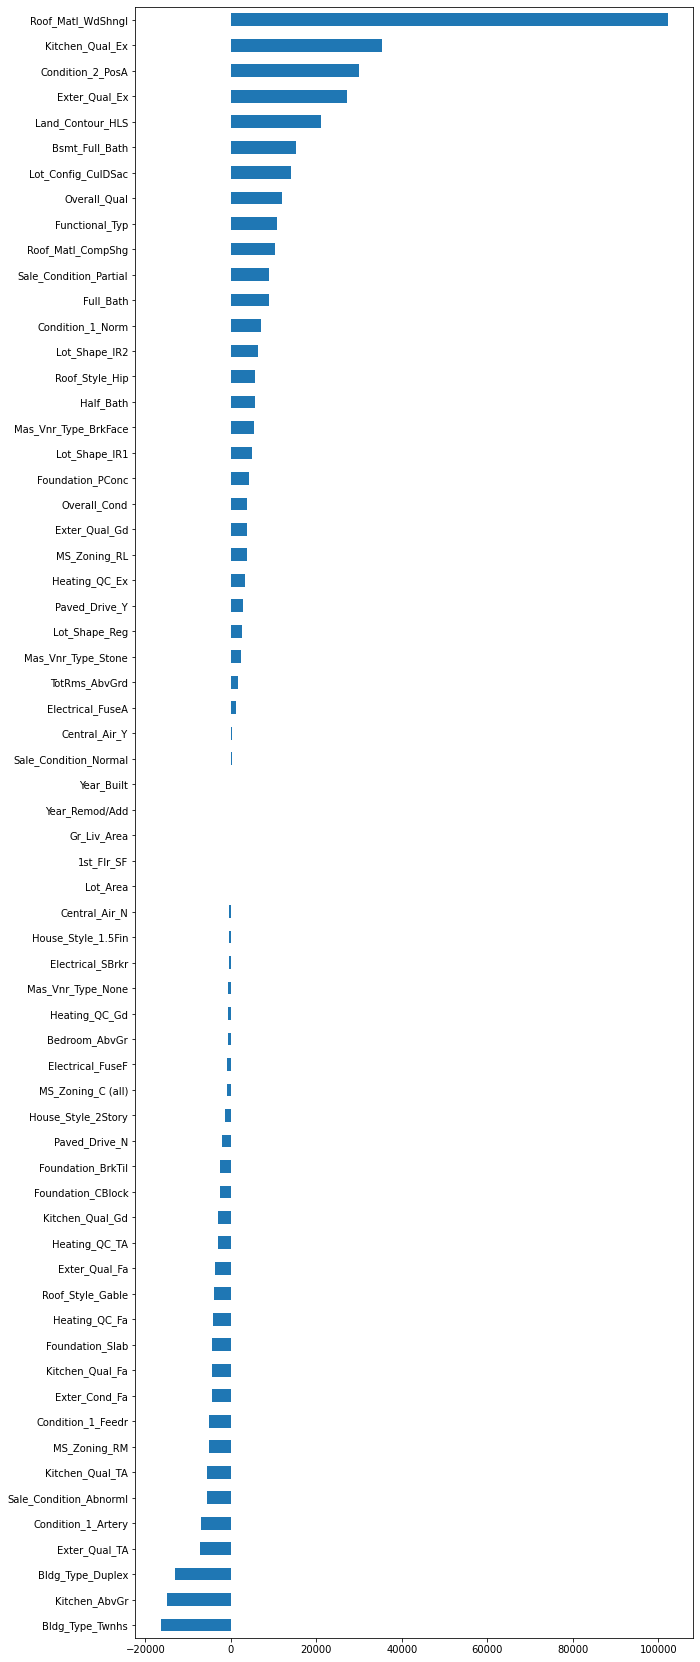

In [25]:
# Get and plot model coefficients.
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,30))

coefficients = pd.Series(ridge.coef_, best_features)
coefficients.sort_values().plot.barh(); #bar charts


# Data Dictionary 

Here's a description of the data fields:

```
1st_Flr_SF: First Floor square feet

Bedroom_AbvGr: Bedrooms above grade (does NOT include basement bedrooms)

Bldg_Type: Type of dwelling
		
       1Fam	Single-family Detached	
       2FmCon	Two-family Conversion; originally built as one-family dwelling
       Duplx	Duplex
       TwnhsE	Townhouse End Unit
       TwnhsI	Townhouse Inside Unit
       
Bsmt_Half_Bath: Basement half bathrooms

Bsmt_Full_Bath: Basement full bathrooms

Central_Air: Central air conditioning

       N	No
       Y	Yes
		
Condition_1: Proximity to various conditions
	
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
	
Condition_2: Proximity to various conditions (if more than one is present)
		
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
       
 Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed
       
 Exter_Cond: Evaluates the present condition of the material on the exterior
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
 
 Exter_Qual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
Exterior_1st: Exterior covering on house

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast	
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
	
Exterior_2nd: Exterior covering on house (if more than one material)

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
       
Foundation: Type of foundation
		
       BrkTil	Brick & Tile
       CBlock	Cinder Block
       PConc	Poured Contrete	
       Slab	Slab
       Stone	Stone
       Wood	Wood
		
Full_Bath: Full bathrooms above grade

Functional: Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only
		
Gr_Liv_Area: Above grade (ground) living area square feet
        
Half_Bath: Half baths above grade

Heating: Type of heating
		
       Floor	Floor Furnace
       GasA	Gas forced warm air furnace
       GasW	Gas hot water or steam heat
       Grav	Gravity furnace	
       OthW	Hot water or steam heat other than gas
       Wall	Wall furnace
		
Heating_QC: Heating quality and condition

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

House_Style: Style of dwelling
	
       1Story	One story
       1.5Fin	One and one-half story: 2nd level finished
       1.5Unf	One and one-half story: 2nd level unfinished
       2Story	Two story
       2.5Fin	Two and one-half story: 2nd level finished
       2.5Unf	Two and one-half story: 2nd level unfinished
       SFoyer	Split Foyer
       SLvl	Split Level

Kitchen_AbvGr: Kitchens above grade

Kitchen_Qual: Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor

LandContour: Flatness of the property

       Lvl	Near Flat/Level	
       Bnk	Banked - Quick and significant rise from street grade to building
       HLS	Hillside - Significant slope from side to side
       Low	Depression
		
Land_Slope: Slope of property
		
       Gtl	Gentle slope
       Mod	Moderate Slope	
       Sev	Severe Slope

Lot_Area: Lot size in square feet

Lot_Config: Lot configuration

       Inside	Inside lot
       Corner	Corner lot
       CulDSac	Cul-de-sac
       FR2	Frontage on 2 sides of property
       FR3	Frontage on 3 sides of property

Lot_Shape: General shape of property

       Reg	Regular	
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular

MS_SubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MS_Zoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density

Mas_Vnr_Type: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone

Mo_Sold: Month Sold (MM)

Neighborhood: Physical locations within Ames city limits

       Blmngtn	Bloomington Heights
       Blueste	Bluestem
       BrDale	Briardale
       BrkSide	Brookside
       ClearCr	Clear Creek
       CollgCr	College Creek
       Crawfor	Crawford
       Edwards	Edwards
       Gilbert	Gilbert
       IDOTRR	Iowa DOT and Rail Road
       MeadowV	Meadow Village
       Mitchel	Mitchell
       Names	North Ames
       NoRidge	Northridge
       NPkVill	Northpark Villa
       NridgHt	Northridge Heights
       NWAmes	Northwest Ames
       OldTown	Old Town
       SWISU	South & West of Iowa State University
       Sawyer	Sawyer
       SawyerW	Sawyer West
       Somerst	Somerset
       StoneBr	Stone Brook
       Timber	Timberland
       Veenker	Veenker
			
Overall_Cond: Rates the overall condition of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average	
       5	Average
       4	Below Average	
       3	Fair
       2	Poor
       1	Very Poor

Overall_Qual: Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor

Paved_Drive: Paved driveway

       Y	Paved 
       P	Partial Pavement
       N	Dirt/Gravel

Roof_Matl: Roof material

       ClyTile	Clay or Tile
       CompShg	Standard (Composite) Shingle
       Membran	Membrane
       Metal	Metal
       Roll	Roll
       Tar&Grv	Gravel & Tar
       WdShake	Wood Shakes
       WdShngl	Wood Shingles

Roof_Style: Type of roof

       Flat	Flat
       Gable	Gable
       Gambrel	Gabrel (Barn)
       Hip	Hip
       Mansard	Mansard
       Shed	Shed

SalePrice: the sales price for each house

Sale_Condition: Condition of sale

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)

Sale_Type: Type of sale
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other
	
Street: Type of road access to property

       Grvl	Gravel	
       Pave	Paved
       	
TotRms_AbvGrd: Total rooms above grade (does not include bathrooms)

Utilities: Type of utilities available
		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only	
	
Year_Built: Original construction date

Year_Remod/Add: Remodel date (same as construction date if no remodeling or additions)
						
Yr_Sold: Year Sold (YYYY)	

```